Using device: cuda
Epoch 100, Total Loss: 1.156349e+05, PDE Loss: 2.381969e-01, BC Loss: 1.156346e+05
Epoch 200, Total Loss: 1.093229e+05, PDE Loss: 5.857108e-01, BC Loss: 1.093223e+05
Epoch 300, Total Loss: 1.033966e+05, PDE Loss: 1.201402e+00, BC Loss: 1.033954e+05
Epoch 400, Total Loss: 9.775653e+04, PDE Loss: 1.943421e+00, BC Loss: 9.775459e+04
Epoch 500, Total Loss: 9.236922e+04, PDE Loss: 2.912986e+00, BC Loss: 9.236630e+04
Epoch 600, Total Loss: 8.721502e+04, PDE Loss: 4.237937e+00, BC Loss: 8.721078e+04
Epoch 700, Total Loss: 8.228156e+04, PDE Loss: 5.854454e+00, BC Loss: 8.227571e+04
Epoch 800, Total Loss: 7.756045e+04, PDE Loss: 8.481489e+00, BC Loss: 7.755196e+04
Epoch 900, Total Loss: 7.303720e+04, PDE Loss: 9.923747e+00, BC Loss: 7.302727e+04
Epoch 1000, Total Loss: 6.871088e+04, PDE Loss: 1.260235e+01, BC Loss: 6.869827e+04
Epoch 1100, Total Loss: 6.457472e+04, PDE Loss: 1.681353e+01, BC Loss: 6.455791e+04
Epoch 1200, Total Loss: 6.061505e+04, PDE Loss: 1.881725e+01, BC L

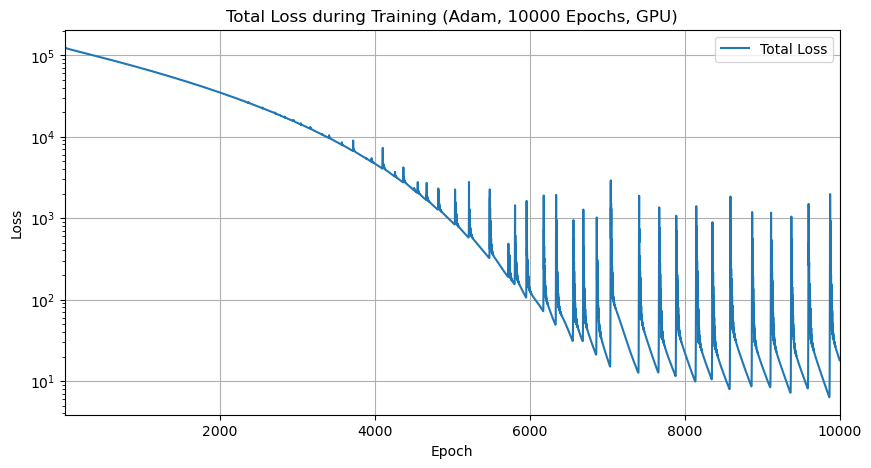

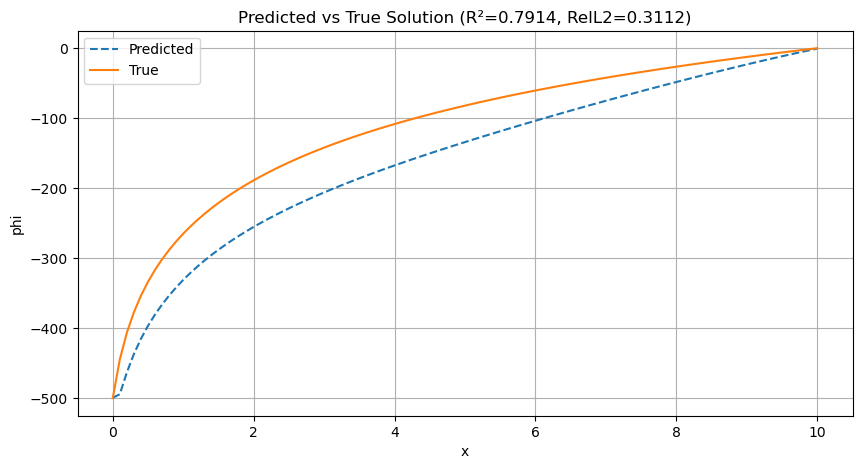

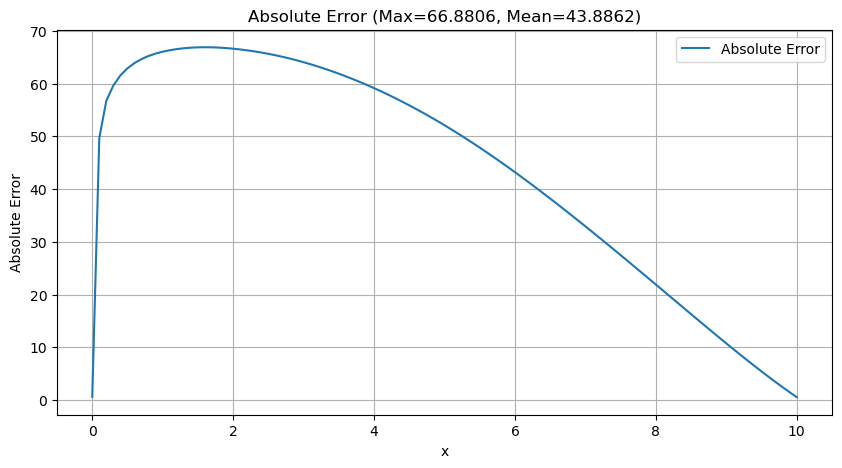

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

# Set random seed for reproducibility
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

# Check GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define parameters for the problem
params = {
    'theta_s': 0.35,  # Saturated water content
    'theta_r': 0.14,  # Residual water content
    'k_s': 0.0001,    # Saturated hydraulic conductivity
    'a': torch.tensor(0.008, device=device),  # Constant in PDE
    'phi_d': torch.tensor(-500.0, device=device)  # Boundary condition value
}

# Define the neural network architecture for the PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Fully connected layers
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.activation = nn.Tanh()  # Tanh activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the PDE residual (the part of the equation that represents the model error)
def pde_residual(net, x):
    x.requires_grad_(True)
    phi = net(x)
    a = params['a']

    # First and second derivatives of phi with respect to x
    dphi_dz = torch.autograd.grad(phi, x, grad_outputs=torch.ones_like(phi, device=device), create_graph=True)[0]
    dphi_dzz = torch.autograd.grad(dphi_dz, x, grad_outputs=torch.ones_like(dphi_dz, device=device), create_graph=True)[0]

    # Residual of the PDE
    pde_res = dphi_dz * a + dphi_dzz + a * dphi_dz**2
    return pde_res

# Define the boundary condition (comparing the predicted solution to the true solution at boundaries)
def boundary_condition(net, x_boundary):
    phi_pred = net(x_boundary)
    phi_true = func(x_boundary)  # True solution from the analytical function
    return torch.mean((phi_pred - phi_true)**2)

# Define the analytical solution (true solution of the PDE for comparison)
def func(x):
    a = params['a'].item()
    phi_d = params['phi_d'].item()
    x_np = x.cpu().detach().numpy()
    term1 = (1 - np.exp(a * phi_d)) * np.exp(a / 2 * (10 - x_np))
    sinh_ratio = np.sinh(a * x_np / 2) / np.sinh(a * 10 / 2)
    term2 = np.exp(a * phi_d)
    return torch.tensor(1 / a * np.log(term1 * sinh_ratio + term2), dtype=torch.float32, device=device)

# Generate training data (uniform points)
def generate_data(n_interior=200):
    x_interior = torch.linspace(0, 10, n_interior, device=device).view(-1, 1)
    x_interior = torch.cat([torch.zeros(1, 1, device=device), x_interior])  # Include boundary at x = 0
    x_interior.requires_grad_(True)
    
    # Boundary conditions at x = 0 and x = 10
    x_boundary = torch.tensor([0.0, 10.0], device=device).view(-1, 1).requires_grad_(True)
    return x_interior, x_boundary

# Define the loss function (PDE loss + boundary condition loss)
def loss_fn(net, x_interior, x_boundary):
    pde_loss = torch.mean(pde_residual(net, x_interior)**2)
    bc_loss = boundary_condition(net, x_boundary)
    total_loss = pde_loss + bc_loss  # Total loss is the sum of PDE loss and BC loss
    return total_loss, pde_loss, bc_loss

# Compute evaluation metrics (R² score, relative L2 error, max and mean absolute error)
def compute_metrics(pred, true):
    r2 = r2_score(true, pred)  # R² score
    relative_l2 = np.linalg.norm(pred - true) / np.linalg.norm(true)  # Relative L2 error
    abs_error = np.abs(pred - true)  # Absolute error
    max_abs_error = np.max(abs_error)
    mean_abs_error = np.mean(abs_error)
    
    return {
        'R2': r2,
        'Relative_L2': relative_l2,
        'Max_Absolute_Error': max_abs_error,
        'Mean_Absolute_Error': mean_abs_error
    }

# Training function (using Adam optimizer)
def train(net, x_interior, x_boundary, n_epochs=10000):
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=1e-3,  # Learning rate
        betas=(0.9, 0.999),
        weight_decay=1e-6  # L2 regularization
    )
    
    # Initialize loss tracking lists
    total_losses = []
    pde_losses = []
    bc_losses = []
    all_epochs = []

    # Training loop
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        total_loss, pde_loss, bc_loss = loss_fn(net, x_interior, x_boundary)
        total_loss.backward()
        optimizer.step()
        
        # Track losses for analysis
        total_losses.append(total_loss.item())
        pde_losses.append(pde_loss.item())
        bc_losses.append(bc_loss.item())
        all_epochs.append(epoch + 1)
        
        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Total Loss: {total_loss.item():.6e}, PDE Loss: {pde_loss.item():.6e}, BC Loss: {bc_loss.item():.6e}")
    
    # Create a DataFrame to save loss data
    loss_data = pd.DataFrame({
        'Epoch': all_epochs,
        'Total_Loss': total_losses,
        'PDE_Loss': pde_losses,
        'BC_Loss': bc_losses
    })
    
    return loss_data

# Main function to run the code
if __name__ == "__main__":
    # Initialize the neural network and move it to the GPU
    net = PINN().to(device)
    # Generate training data
    x_interior, x_boundary = generate_data()
    # Train the model and obtain the loss data
    loss_data = train(net, x_interior, x_boundary, n_epochs=10000)
    
    # Save loss data to an Excel file
    loss_data.to_excel('training_losses_tanh.xlsx', index=False)
    print("Training losses saved to 'training_losses.xlsx'")

    # Test the model (with uniform points for evaluation)
    x_test = torch.linspace(0, 10, 101, device=device).view(-1, 1)
    phi_pred = net(x_test).detach().cpu().numpy().flatten()
    phi_true = func(x_test).cpu().numpy().flatten()

    # Compute evaluation metrics
    metrics = compute_metrics(phi_pred, phi_true)
    
    # Print evaluation metrics
    print("\nModel Evaluation Metrics:")
    print(f"R² Score: {metrics['R2']:.6f}")
    print(f"Relative L2 Error: {metrics['Relative_L2']:.6f}")
    print(f"Max Absolute Error: {metrics['Max_Absolute_Error']:.6f}")
    print(f"Mean Absolute Error: {metrics['Mean_Absolute_Error']:.6f}")

    # Create a DataFrame for predictions and metrics
    prediction_data = pd.DataFrame({
        'x': x_test.cpu().numpy().flatten(),
        'Predicted': phi_pred,
        'True': phi_true,
        'Absolute_Error': np.abs(phi_pred - phi_true)
    })
    
    # Add evaluation metrics to the DataFrame
    metrics_df = pd.DataFrame([metrics])
    prediction_data = pd.concat([prediction_data, metrics_df], axis=1)
    
    # Save the predictions and metrics to an Excel file
    prediction_data.to_excel('predictions_with_metrics_tanh.xlsx', index=False)
    print("\nPrediction results with metrics saved to 'predictions_with_metrics.xlsx'")

    # Plot the total loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(loss_data['Epoch'], loss_data['Total_Loss'], label='Total Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Total Loss during Training (Adam, {len(loss_data)} Epochs, GPU)")
    plt.legend()
    plt.yscale('log')
    plt.grid(True)
    plt.xlim(1, len(loss_data))
    plt.savefig('losses_adam_gpu.png')
    plt.show()

    # Plot predicted vs true solution
    plt.figure(figsize=(10, 5))
    plt.plot(prediction_data['x'], prediction_data['Predicted'], linestyle='--', label="Predicted")
    plt.plot(prediction_data['x'], prediction_data['True'], linestyle='-', label="True")
    plt.xlabel("x")
    plt.ylabel("phi")
    plt.title(f"Predicted vs True Solution (R²={metrics['R2']:.4f}, RelL2={metrics['Relative_L2']:.4f})")
    plt.legend()
    plt.grid(True)
    plt.savefig('predicted_vs_true_adam_gpu.png')
    plt.show()

    # Plot absolute error
    plt.figure(figsize=(10, 5))
    plt.plot(prediction_data['x'], prediction_data['Absolute_Error'], label="Absolute Error")
    plt.xlabel("x")
    plt.ylabel("Absolute Error")
    plt.title(f"Absolute Error (Max={metrics['Max_Absolute_Error']:.4f}, Mean={metrics['Mean_Absolute_Error']:.4f})")
    plt.legend()
    plt.grid(True)
    plt.savefig('absolute_error_adam_gpu.png')
    plt.show()
